# Data Engineering Assignment

## 1. Understanding the problem

How can a device be malfunctioning?

1. There are not enough samples for a given time series (based on the number of samples of the on_wrist series)
2. Wrong readings when the device is being worn (out of scale measures)
3. Wrong readings when the device is not being worn

As for 1.: we can see that normalizing the samples to 64 Hz gives out enough samples so that it looks like there is no issue in the sample transmission. Therefore, we can exclude this possible cause

In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from pandas.plotting._matplotlib.style import get_standard_colors

In [2]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):


    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = get_standard_colors(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])
        
        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    plt.show()
    return ax

In [ ]:
!ls raw_bucket/2021/02/02

In [ ]:
!ls raw_bucket/2021/02/02/device_001

In [ ]:
df_ppg_green = pd.read_csv('raw_bucket/2021/02/02/device_001/ppg_green.csv', header=None)
df_temperature = pd.read_csv('raw_bucket/2021/02/02/device_001/temperature.csv', header=None)

In [14]:
def get_metrics(df, condition):
    return df[condition].describe()

## 2. Let's take a look at the data

device_009


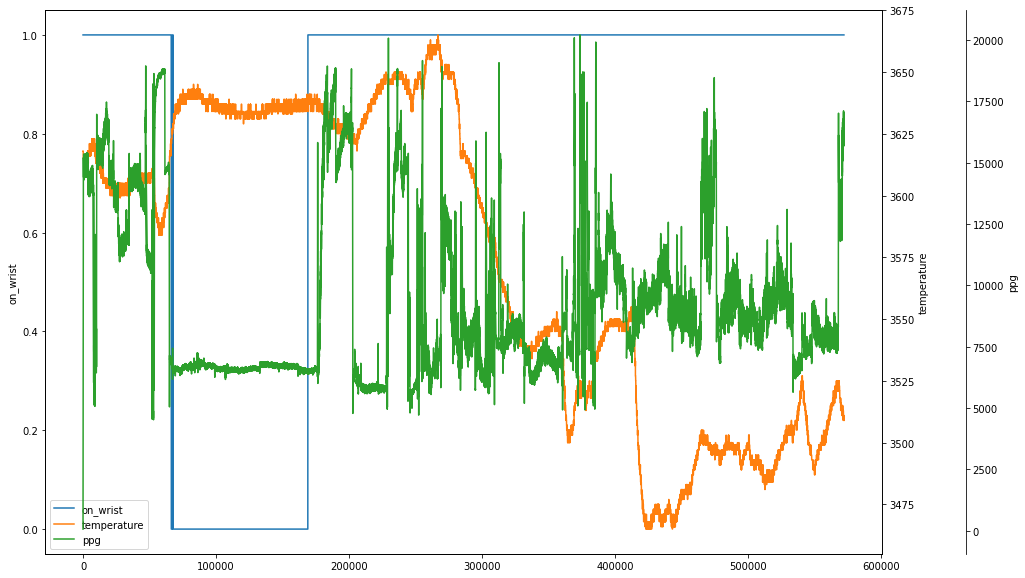

-------------------------
device_019


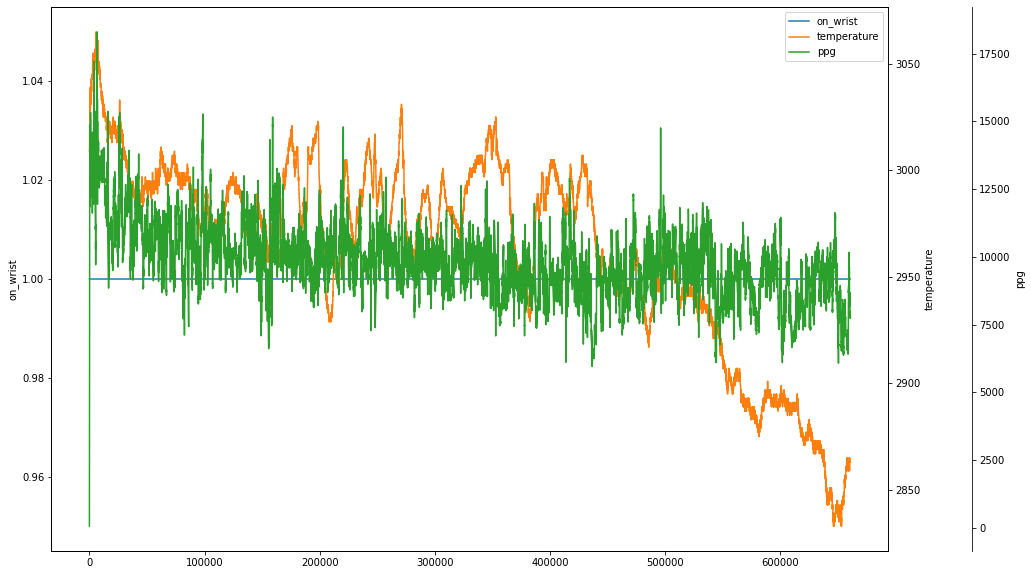

-------------------------
device_002


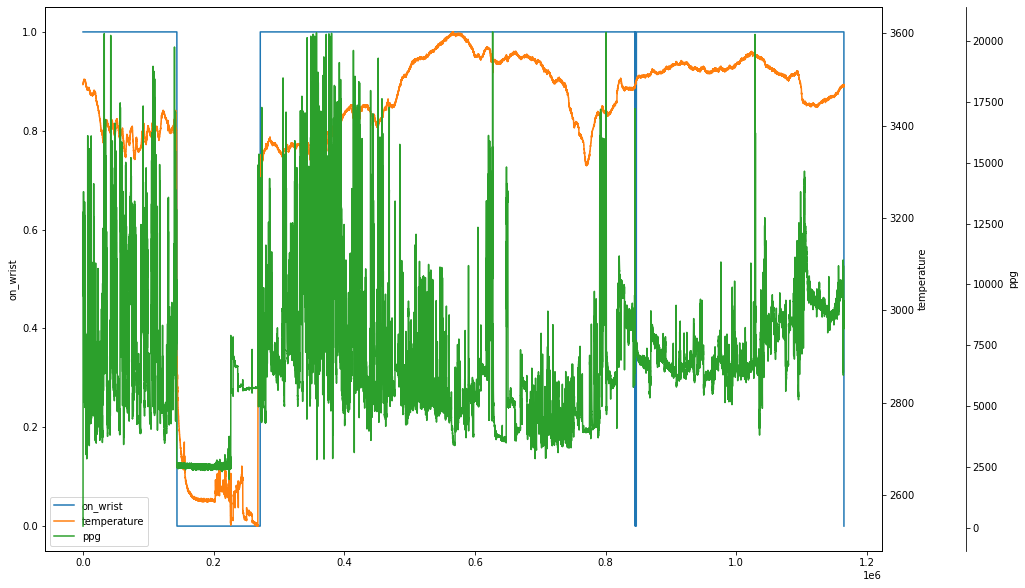

-------------------------
device_013


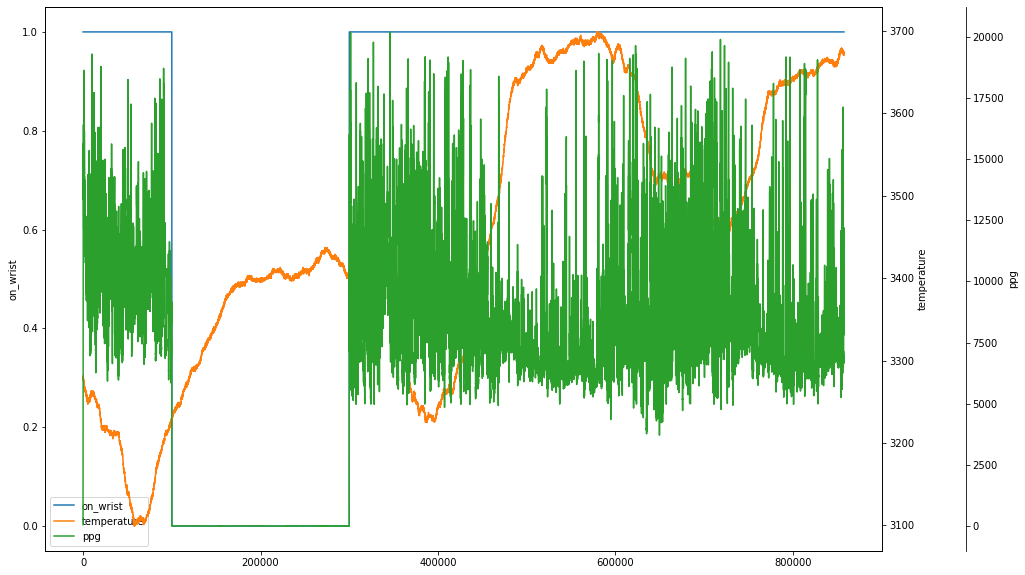

-------------------------
device_014


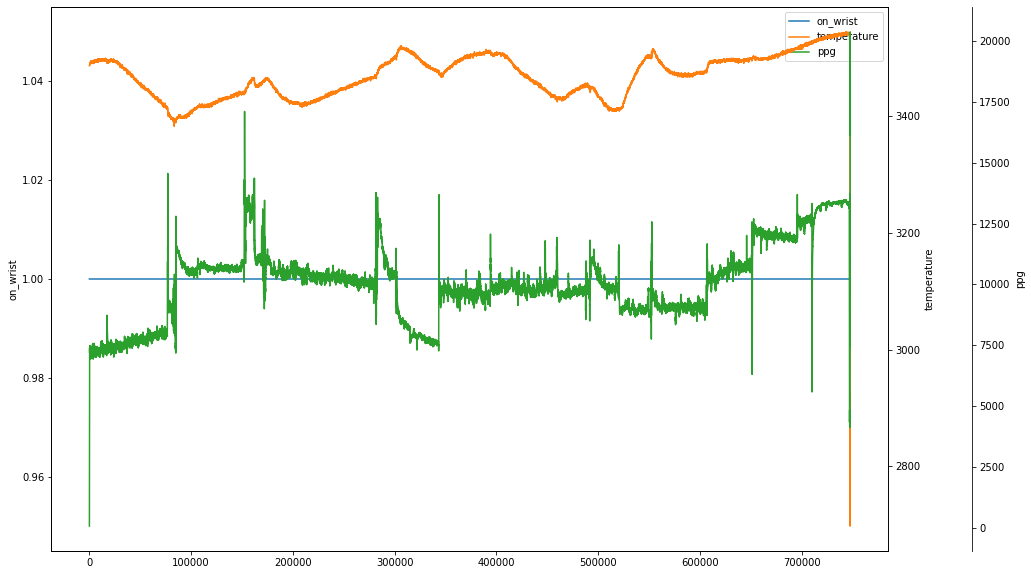

-------------------------
device_015


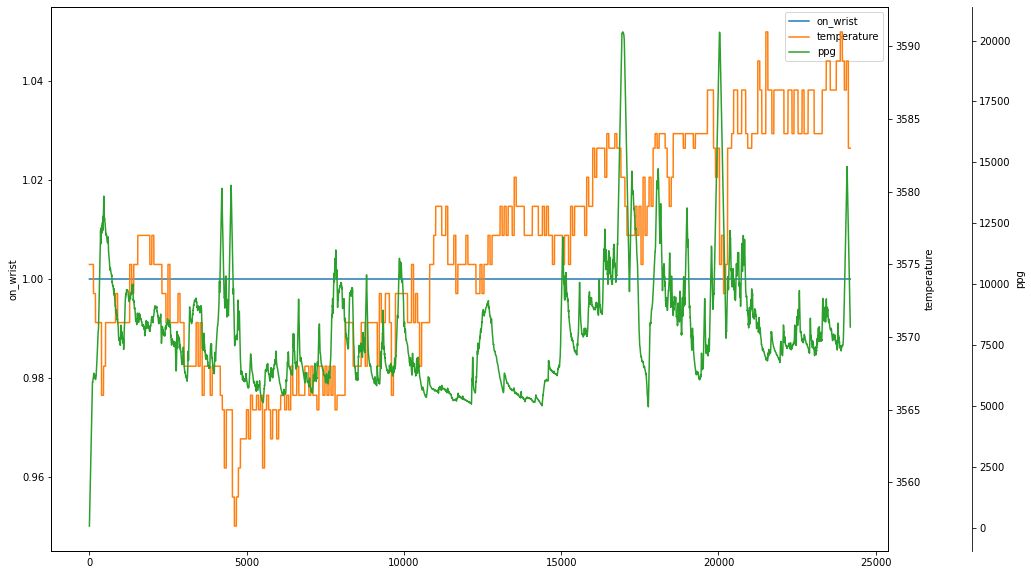

-------------------------
device_012


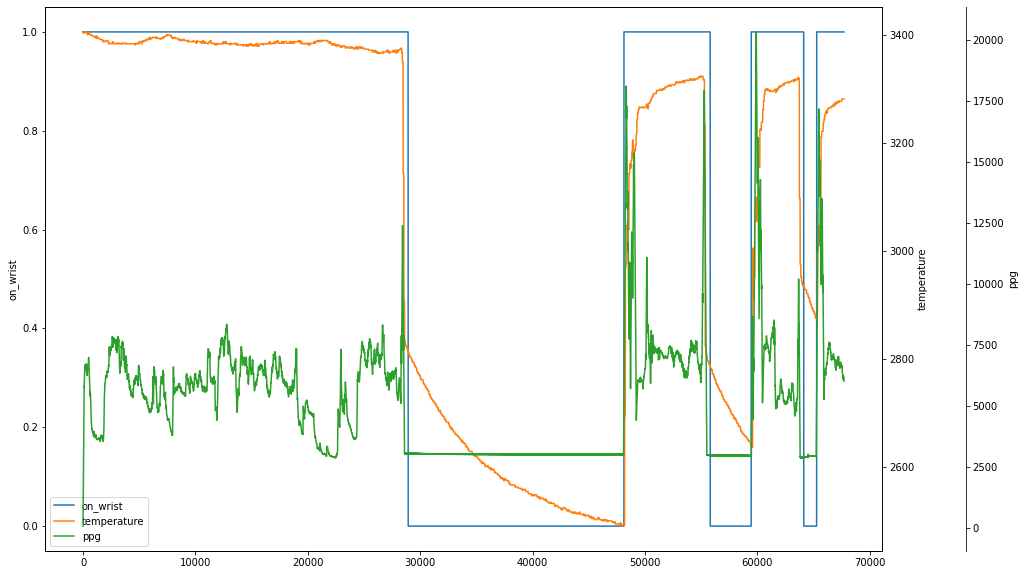

-------------------------
device_006


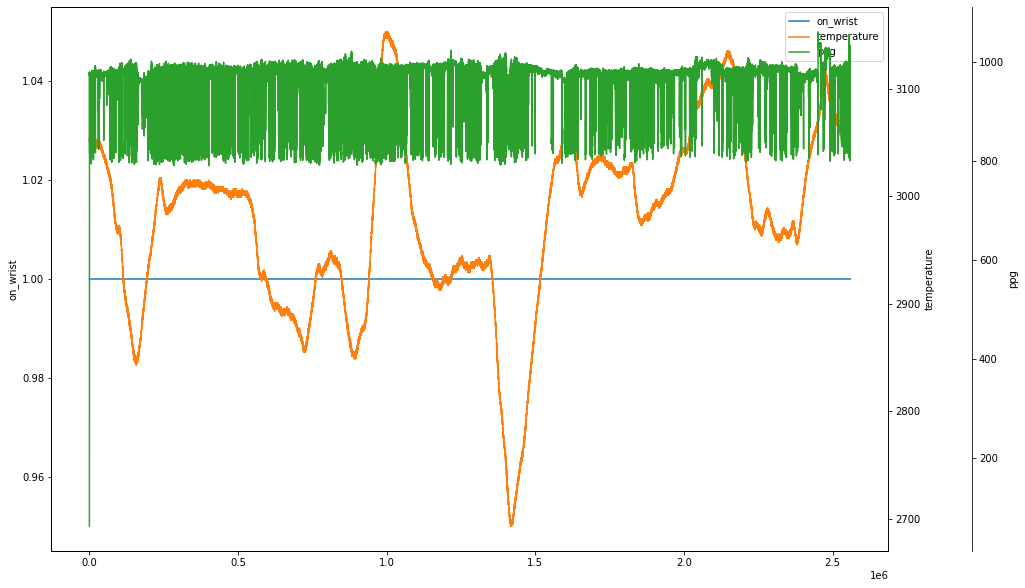

-------------------------
device_008


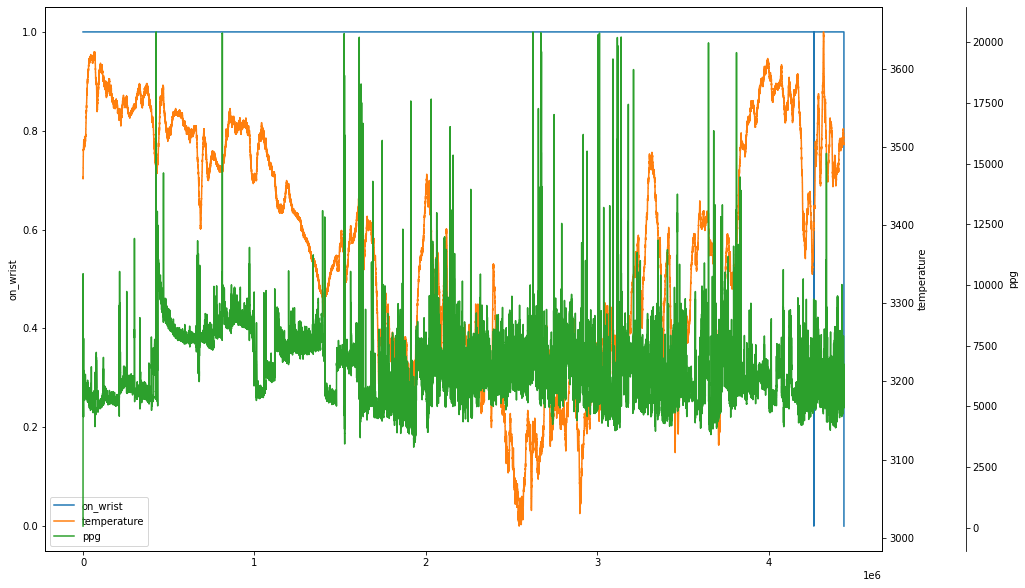

-------------------------
device_007


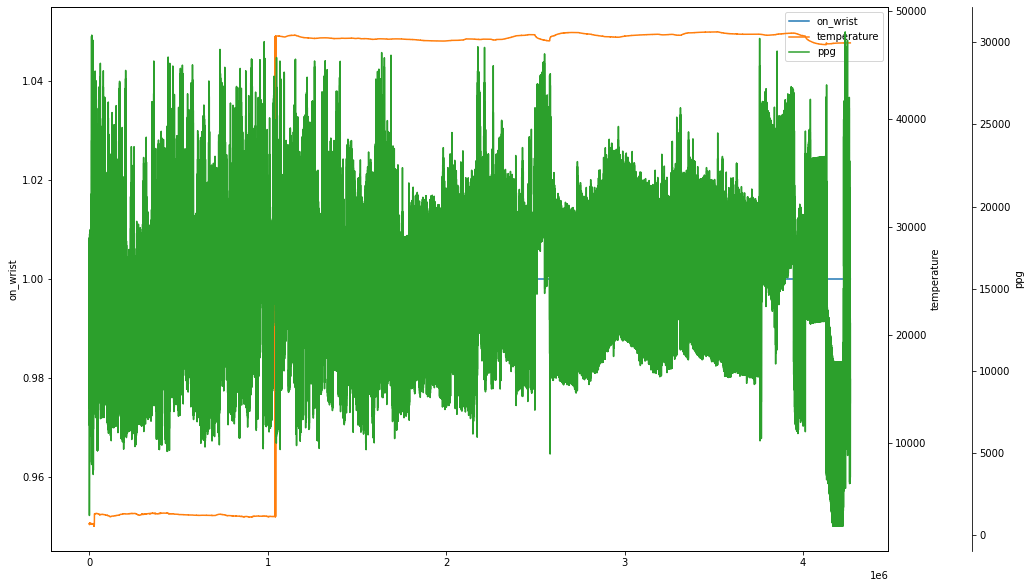

-------------------------
device_010


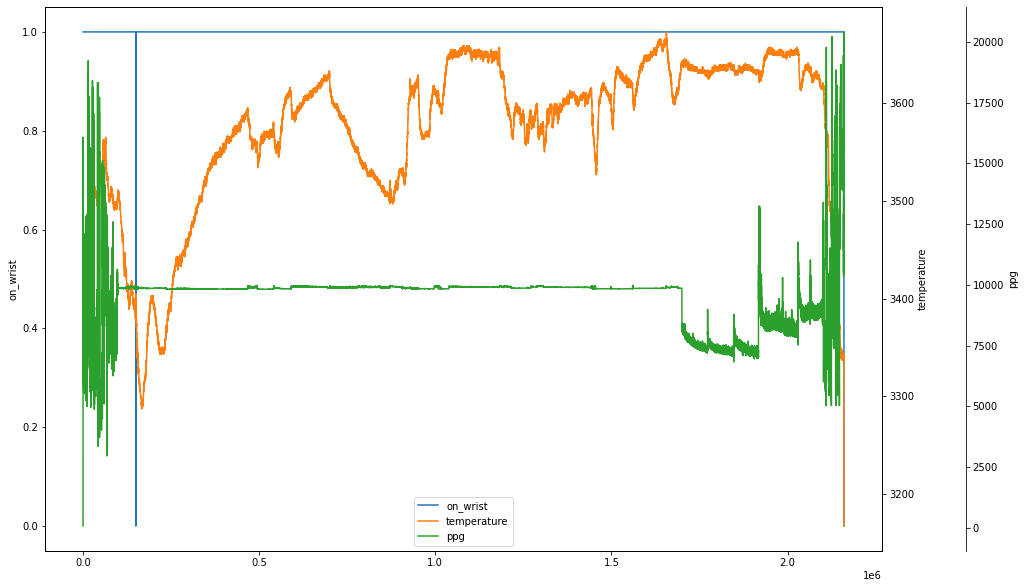

-------------------------
device_011


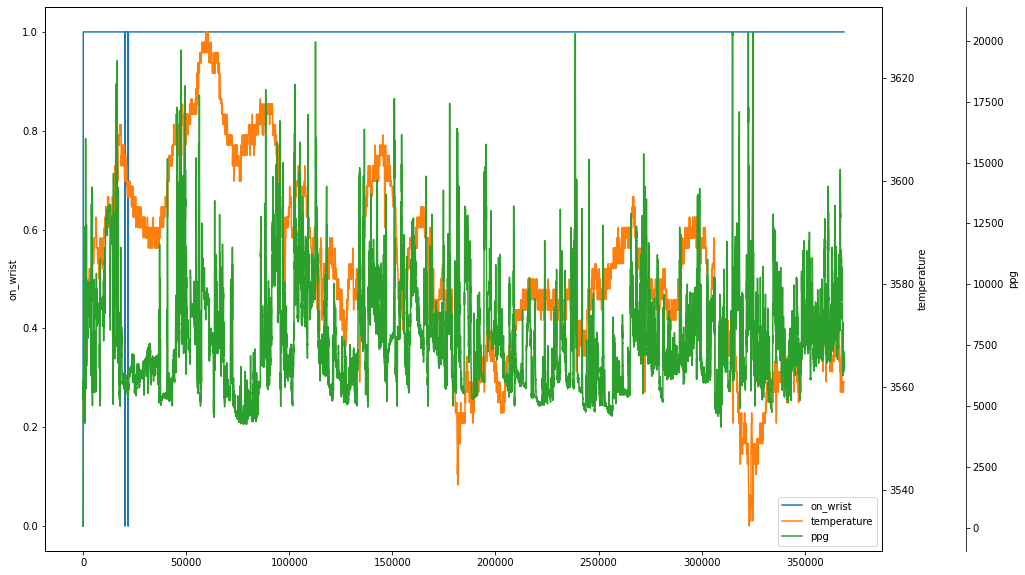

-------------------------
device_018


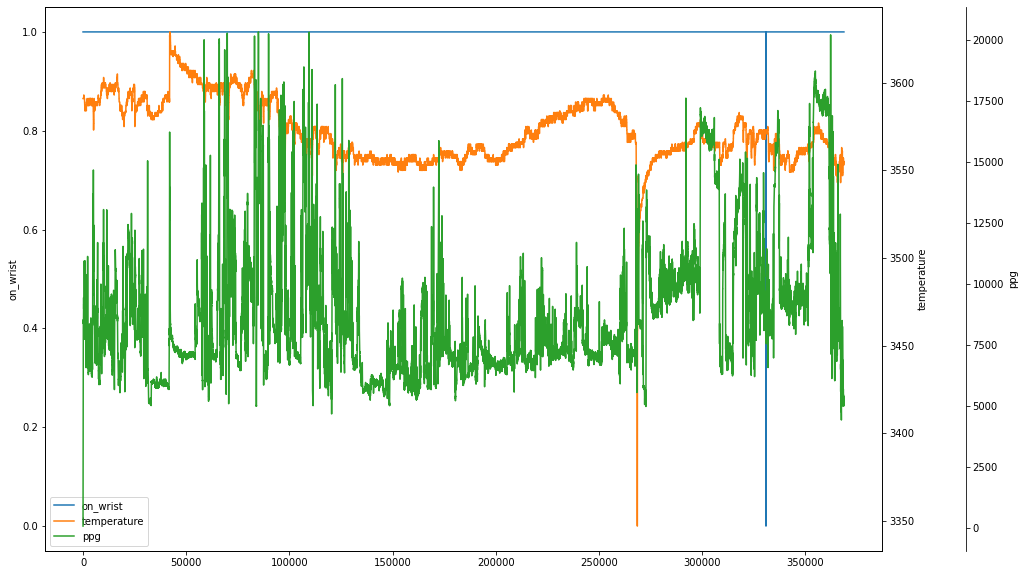

-------------------------
device_001


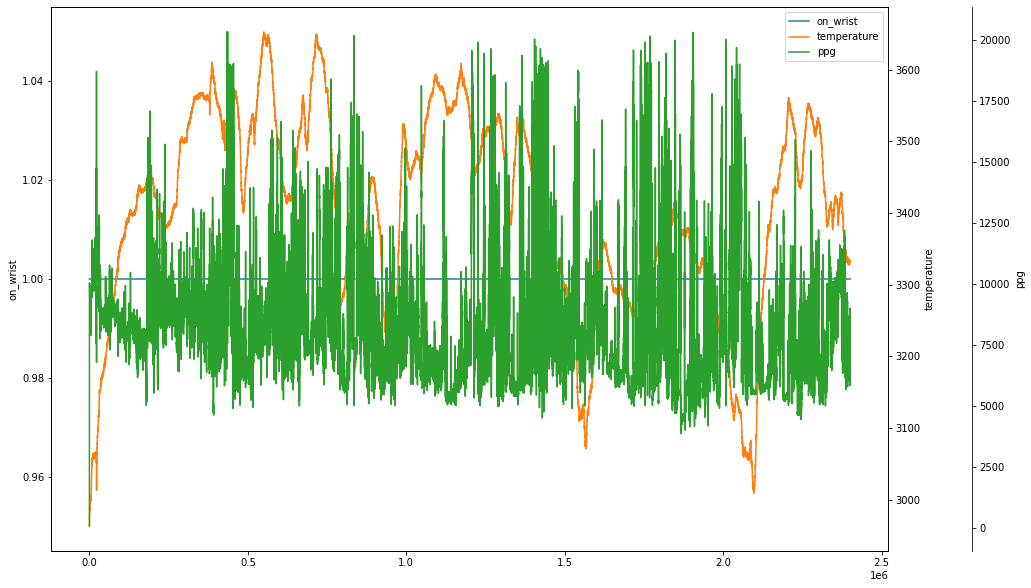

-------------------------
device_017


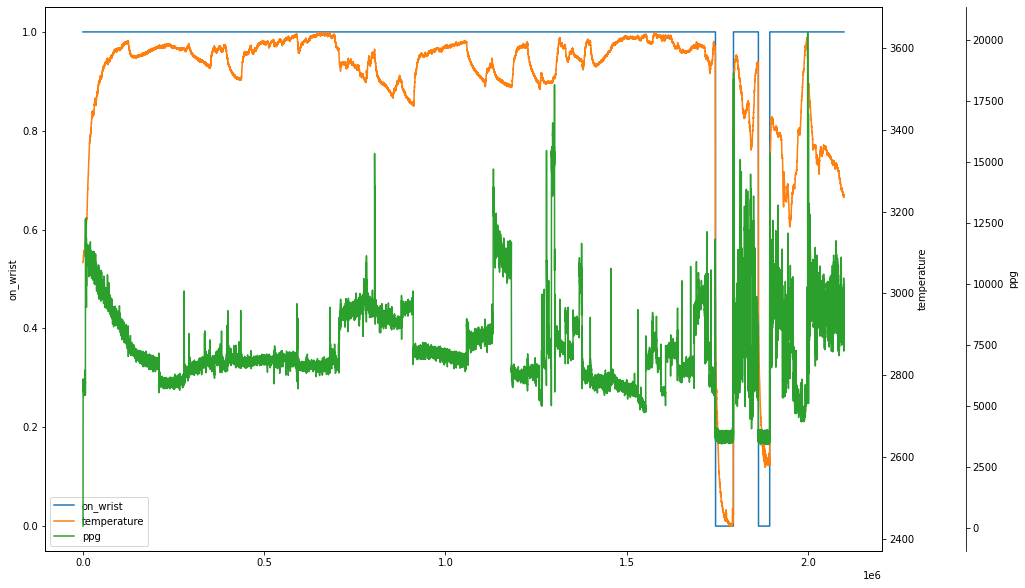

-------------------------
device_016


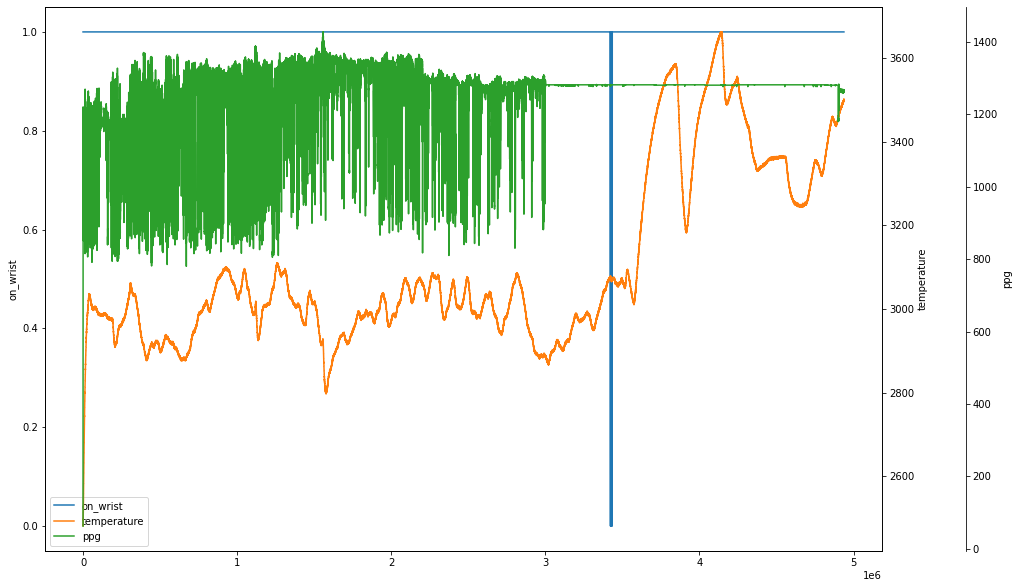

-------------------------
device_005


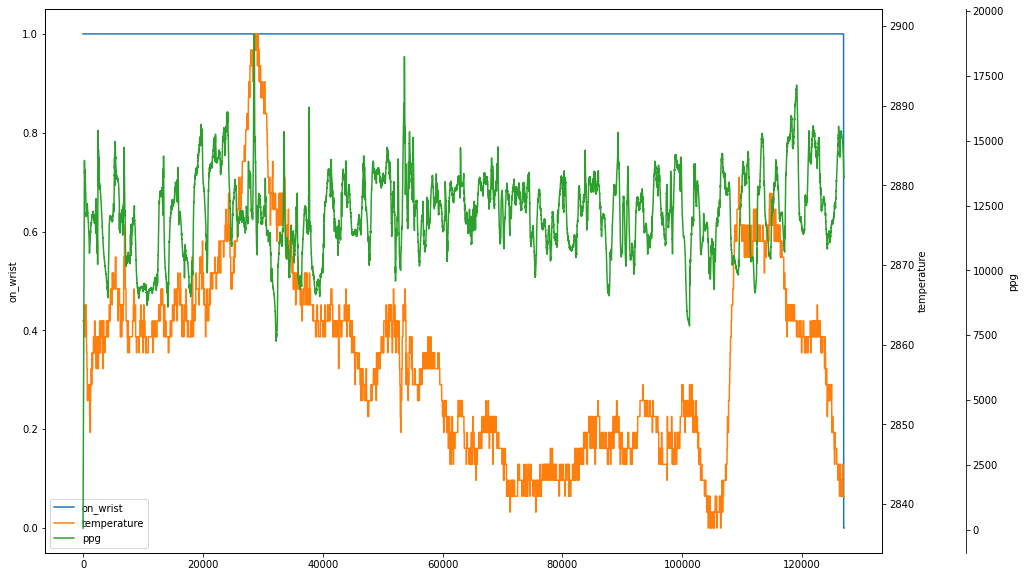

-------------------------
device_003


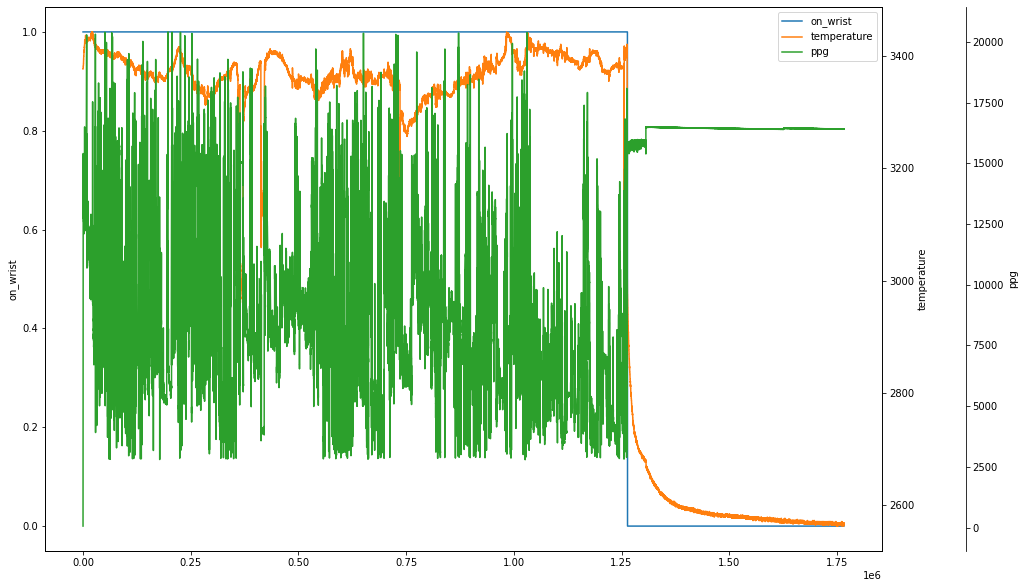

-------------------------
device_004


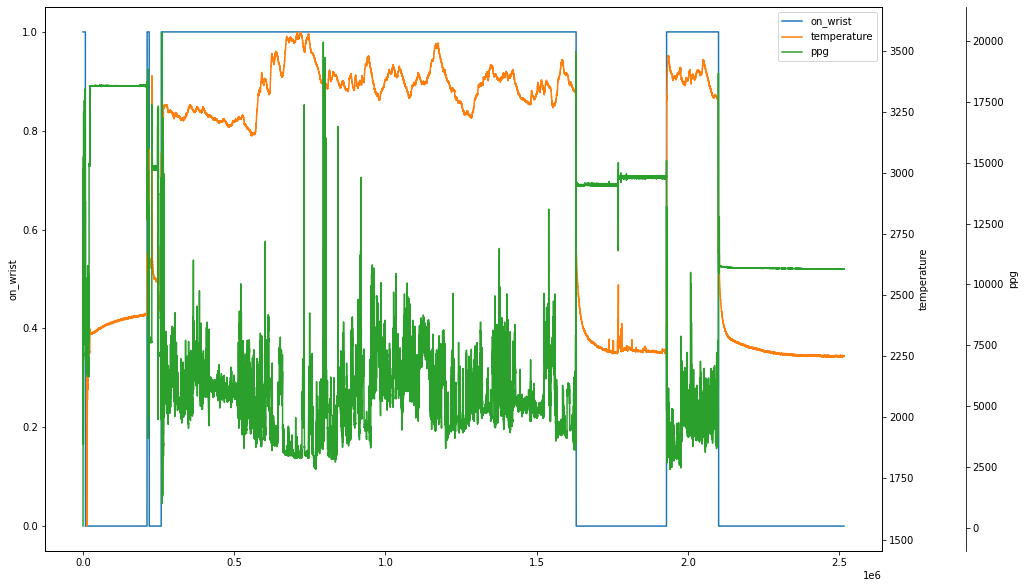

-------------------------


In [28]:
for root, d, files in os.walk('raw_bucket'):
    if files and re.match(r'raw_bucket/\d{4}/\d{2}/\d{2}/device_\d{3}', root):
        csvs = [os.path.join(root, file) for file in files if file.endswith('csv')]
        dfs = [pd.read_csv(path, header=None) for path in csvs]
        
        on_wrist = dfs[0].loc[dfs[0].index.repeat(64)].reset_index(drop=True)
        temperature = dfs[1].loc[dfs[1].index.repeat(16)].reset_index(drop=True)
        ppg = dfs[2]
            
        wrist_samples = len(on_wrist)
        temp_samples = len(temperature)
        ppg_samples = len(ppg)
            
        cut_off = min(wrist_samples, temp_samples, ppg_samples)
            
        complete = pd.DataFrame({
                'on_wrist': on_wrist[0][:cut_off],
                'temperature': temperature[0][:cut_off],
                'ppg': ppg[0][:cut_off]
                
        })
        
        print(root.split('/')[-1])
        plot_multi(complete, figsize=(15, 10))
        print('-------------------------')

## Simulation for 3 days

In [66]:
from concurrent.futures import ThreadPoolExecutor
from datetime import date, timedelta
from pathlib import Path
import os
import re

BASE_DIR = Path('raw_bucket')
WORKERS = os.getenv('WORKERS')

TEMPERATURE_STD_THRESHOLD = 200
PPG_STD_WRIST_ON_THRESHOLD = 3000
PPG_STD_WRIST_OFF_THRESHOLD = 200

PPG_SAMPLING_RATE = 64
ON_WRIST_SAMPLING_RATE = 1
TEMPERATURE_SAMPLING_RATE = 4

TEMPERATURE_WRIST_ON_THRESHOLD = (2700, 3700)
TEMPERATURE_WRIST_OFF_LOWER_THRESHOLD = 2700

def load_data(path: Path) -> pd.DataFrame():
    csvs = [file_path for file_path in path.iterdir() if str(file_path).endswith('csv')]
    dfs = [pd.read_csv(file_path, header=None) for file_path in csvs]
        
    on_wrist = dfs[0].loc[dfs[0].index.repeat(PPG_SAMPLING_RATE / ON_WRIST_SAMPLING_RATE)].reset_index(drop=True)
    temperature = dfs[1].loc[dfs[1].index.repeat(PPG_SAMPLING_RATE / TEMPERATURE_SAMPLING_RATE)].reset_index(drop=True)
    ppg = dfs[2]
            
    wrist_samples = len(on_wrist)
    temp_samples = len(temperature)
    ppg_samples = len(ppg)
            
    cut_off = min(wrist_samples, temp_samples, ppg_samples)
            
    complete = pd.DataFrame({
                'on_wrist': on_wrist[0][:cut_off],
                'temperature': temperature[0][:cut_off],
                'ppg': ppg[0][:cut_off]
                
    })
    return complete

def is_device_faulty_wrist_on(df: pd.DataFrame, indices) -> bool:
    """
    While the device is worn we expect that standard deviation of the two sensors
    is reasonable
    """
    is_device_faulty = False
    
    for group, index in indices.items():
        df_on_sequence = df.iloc[index]
        # Windows based on when the sensors are actually worn
        windows = df_on_sequence.reset_index(drop=True).rolling(window=16)

        temp_std: pd.DataFrame = windows.temperature.std()
        ppg_std = windows.ppg.std()

        temp_over_threshold = temp_std[temp_std > TEMPERATURE_STD_THRESHOLD]
        ppg_over_threshold = ppg_std[ppg_std > PPG_STD_WRIST_ON_THRESHOLD]
        
        is_device_faulty = is_device_faulty or (len(temp_over_threshold) > 16) or (len(ppg_over_threshold) > 64)
            
    return is_device_faulty

def is_device_faulty_wrist_off(df: pd.DataFrame, indices) -> bool: 
    """
    
    """
    is_device_faulty = False
    
    for group, index in indices.items():
        
        if len(index) > 64:
            df_off_sequence = df.iloc[index]
            # Windows based on when the sensors are actually not worn
            windows = df_off_sequence.reset_index(drop=True).rolling(window=16)
            ppg_std = windows.ppg.std()
            ppg_over_threshold = ppg_std[ppg_std > PPG_STD_WRIST_OFF_THRESHOLD]
            
            temperature_under_threshold = df_off_sequence[
                df_off_sequence['temperature'] > TEMPERATURE_WRIST_OFF_LOWER_THRESHOLD
            ]
            temperature_gradient = np.gradient(df_off_sequence.temperature, 4)
            ppg_gradient = np.gradient(df_off_sequence.ppg, 1)
            is_ppg_decreasing = ppg_gradient.sum() <= 0
            is_temperature_decreasing = temperature_gradient.sum() <= 0

            is_device_faulty = is_device_faulty or len(ppg_over_threshold) > 64 # not is_temperature_decreasing # or not is_ppg_decreasing
    
    return is_device_faulty


def is_device_faulty(df: pd.DataFrame) -> bool:
    wrist_on = df[df['on_wrist'] == 1].drop(columns=['on_wrist'])
    wrist_off = df[df['on_wrist'] == 0].drop(columns=['on_wrist'])
        
    indices_wrist_on = wrist_on.groupby(wrist_on.index.to_series().diff().ne(1).cumsum()).groups
    indices_wrist_off = wrist_off.groupby(wrist_off.index.to_series().diff().ne(1).cumsum()).groups
        
    is_device_faulty_on = is_device_faulty_wrist_on(df.copy(), indices_wrist_on)
    is_device_faulty_off = is_device_faulty_wrist_off(df.copy(), indices_wrist_off)
    
    return is_device_faulty_on or is_device_faulty_off

def send_alert(df, device_name):
    print("Device", device_name, "is malfunctioning!")
    plot_multi(df, figsize=(15, 10))

def device_alert(device_path: Path):
    device_name = device_path.name
    df = load_data(device_path)
    
    if is_device_faulty(df):
        send_alert(df, device_name)


def process_day(day: date = date.today() - timedelta(days=1)):
    today_dir = Path(os.path.join(BASE_DIR, day.strftime('%Y/%m/%d')))
    
    devices = [device for device in today_dir.iterdir() if re.match(r'device_\d{3}', device.name)]
    
    for device in devices:
        device_alert(device)
    # with ThreadPoolExecutor(workers=WORKERS or len(devices)) as executor:
    #    results = executor.map(device_alert, devices)

Device device_004 is malfunctioning!


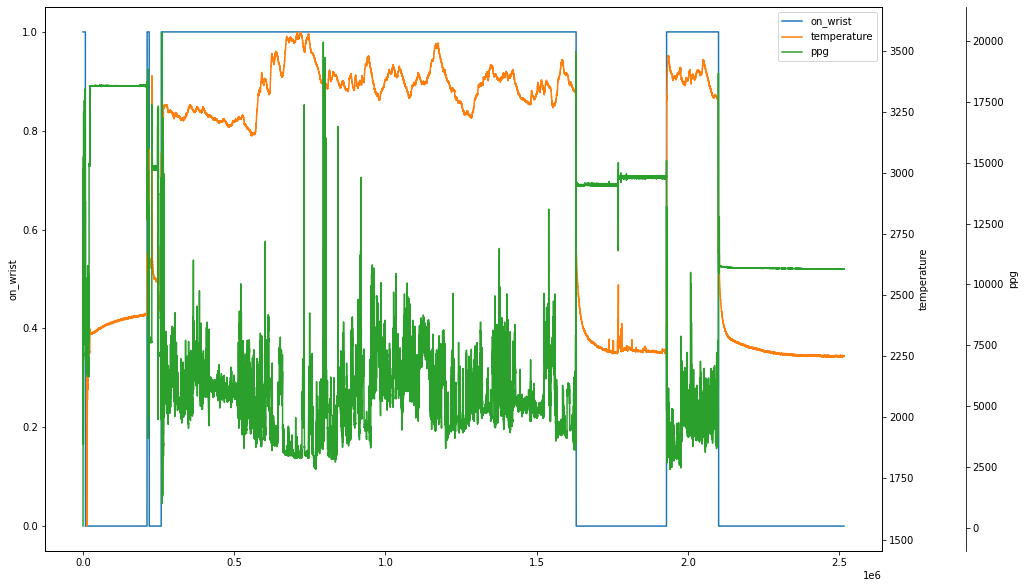

Device device_002 is malfunctioning!


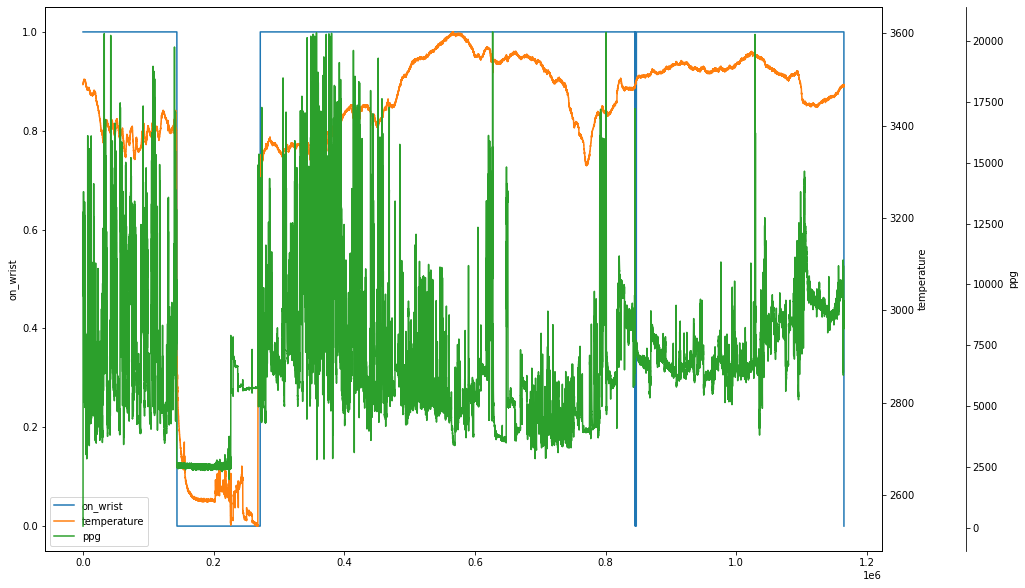

Device device_007 is malfunctioning!


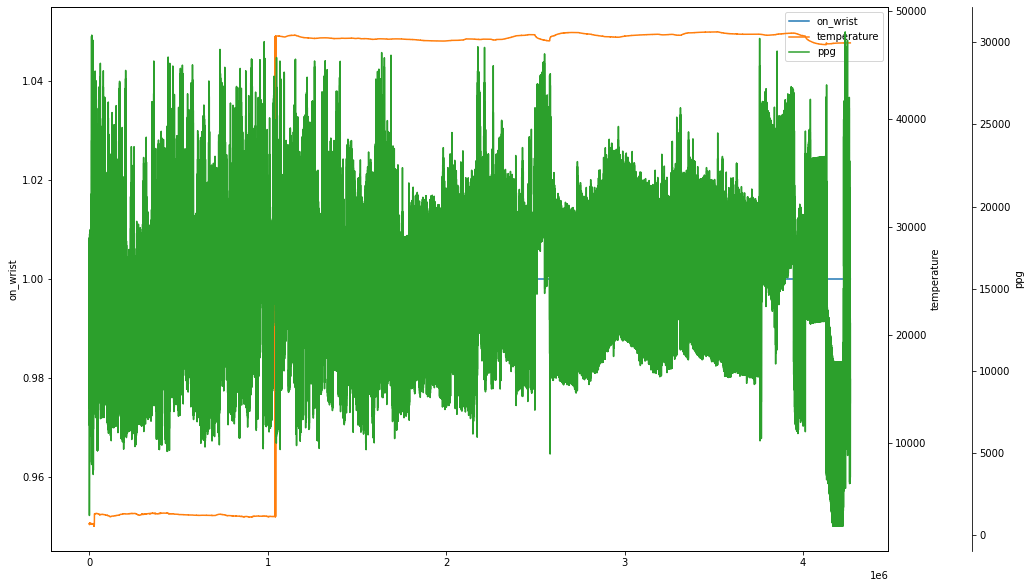

In [67]:
days = ['2021-02-02', '2021-02-03', '2021-02-04']

for day in days:
    process_day(date.fromisoformat(day))

In [8]:
windows = complete.rolling(window=16)

In [15]:
stds = windows.temperature.std()

stds[stds > TEMPERATURE_STD_THRESHOLD]

27653        208.000000
27654        213.136576
27655        214.821476
27656        213.136576
27657        208.000000
               ...     
1043402    21282.647178
1043403    19882.222029
1043404    17921.592749
1043405    15185.297905
1043406    11114.500000
Name: temperature, Length: 110, dtype: float64

In [18]:
ppg_stds = windows.ppg.std()

ppg_stds[ppg_stds > PPG_STD_THRESHOLD]

15         2519.155040
16         2753.168805
17         2782.889708
18         2839.884792
19         2806.174404
              ...     
4265851    2837.485294
4265852    2852.583461
4265853    2519.174121
4265854    2443.138160
4265855    2375.862805
Name: ppg, Length: 4265841, dtype: float64